In [1]:
import pyadq
from typing import List
import numpy as np
import cupyx
import cupy
import time
import datetime
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
#!/usr/bin/env python3
# Copyright 2022 Teledyne Signal Processing Devices Sweden AB
"""
 Example illustrating the data acquisition for a ADQ3 series digitizer. The
 example will list the available devices and acquire data from the first
 device.
"""

import pyadq
from typing import List

# Record length in samples
RECORD_LENGTH = 2**16
# Number of records to collect per channel
NOF_RECORDS = 5
# Periodic event generator frequency in Hz
PERIODIC_EVENT_GENERATOR_FREQUENCY = 10e3

SIZEOF_INT16 = 2
NOF_RECORDS_PER_BUFFER = 1

nof_chan = 1

# Create the control unit
acu: pyadq.ADQControlUnit = pyadq.ADQControlUnit()

# Enable trace logging
acu.ADQControlUnit_EnableErrorTrace(pyadq.LOG_LEVEL_INFO, ".")

# List the available devices
device_list: List[pyadq.ADQInfoListEntry] = acu.ListDevices()

print(f"Found {len(device_list)} device(s)")

# Ensure that at least one device is available
assert device_list

# Set up the first available device
device_to_open = 0
dev: pyadq.ADQ = acu.SetupDevice(device_to_open)

print(f"Setting up data collection for: {dev}")

# Initialize the parameters with default values
parameters: pyadq.ADQParameters = dev.InitializeParameters(pyadq.ADQ_PARAMETER_ID_TOP)

# Set up data collection for all channels
for acq_param in parameters.acquisition.channel[0 : nof_chan]:
    acq_param.record_length = RECORD_LENGTH
    acq_param.nof_records = pyadq.ADQ_INFINITE_NOF_RECORDS
    acq_param.trigger_edge = pyadq.ADQ_EDGE_RISING
    acq_param.trigger_source = pyadq.ADQ_EVENT_SOURCE_PERIODIC

# Configure data transfer parameters for all channels
for transfer_param in parameters.transfer.channel[0 : nof_chan]:
    transfer_param.record_size = SIZEOF_INT16 * RECORD_LENGTH
    transfer_param.record_length_infinite_enabled = 0
    transfer_param.record_buffer_size = (
        NOF_RECORDS_PER_BUFFER * SIZEOF_INT16 * RECORD_LENGTH
    )
    # Enable metadata (record headers)
    transfer_param.metadata_enabled = 1
    transfer_param.metadata_buffer_size = (
        NOF_RECORDS_PER_BUFFER * pyadq.SIZEOF_ADQ_GEN4_HEADER
    )
    transfer_param.nof_buffers = pyadq.ADQ_MAX_NOF_BUFFERS

# Configure transfer globals
parameters.transfer.common.transfer_records_to_host_enabled = 0


# Configure the periodic event generator
parameters.event_source.periodic.frequency = PERIODIC_EVENT_GENERATOR_FREQUENCY

# Set parameters
dev.SetParameters(parameters)

# Start the data acquisition
print("Starting data acquisition")
result = dev.ADQ_StartDataAcquisition()
if result != pyadq.ADQ_EOK:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )

record_count = 0
records_to_collect = NOF_RECORDS * nof_chan
try:
    while record_count < records_to_collect:
        # Wait for a record buffer on any channel with 1000 ms timeout
        record_buffer = dev.WaitForRecordBuffer(pyadq.ADQ_ANY_CHANNEL, 1000)

        # Print some header information
        print(
            f"S/N: {record_buffer.header.serial_number}, "
            f"channel {record_buffer.header.channel}"
        )
        print(f"\tRecord number: {record_buffer.header.record_number}")
        print(f"\tRecord length: {record_buffer.header.record_length}")
        print(f"\tData: {record_buffer.data}")

        record_count += 1

except Exception as e:
    dev.ADQ_StopDataAcquisition()
    raise e

# Stop the data acquisition
print("Stopping data acquisition")
result = dev.ADQ_StopDataAcquisition()
if result not in [pyadq.ADQ_EOK, pyadq.ADQ_EINTERRUPTED]:
    raise Exception(
        f"ADQ_StartDataAcquisition failed with error code {result}. See log file."
    )


Found 1 device(s)


Error: Canceled future for execute_request message before replies were done

In [21]:
pyadq.ADQ_MAX_NOF_BUFFERS

16

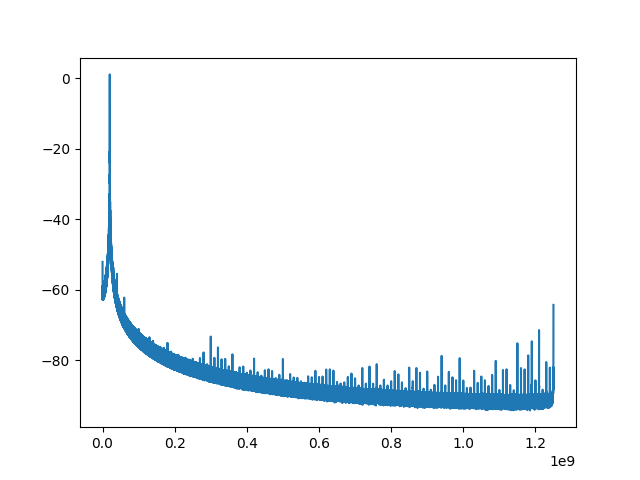

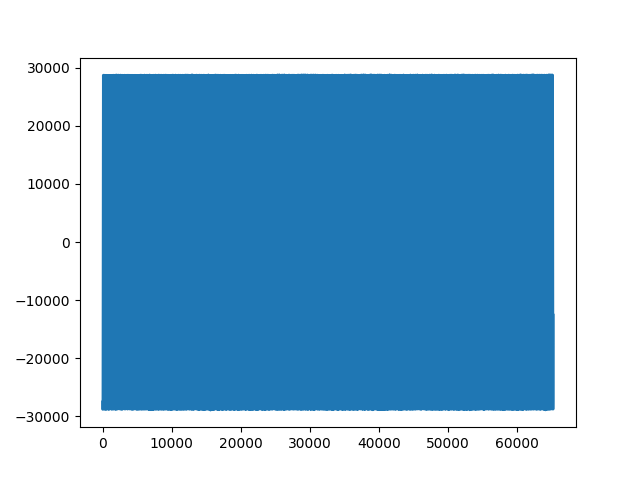

In [4]:
plt.figure()
plt.plot(np.linspace(0,1.25e9,len(avg)),10*np.log10((avg)/averages))

plt.figure()
plt.plot(data)

In [261]:
avgTemp = avg

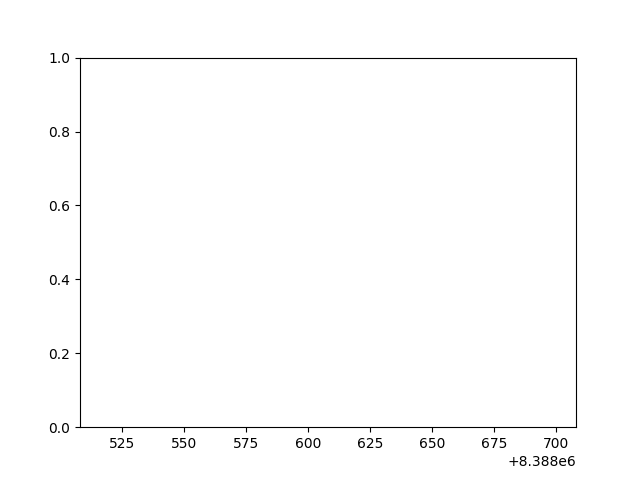

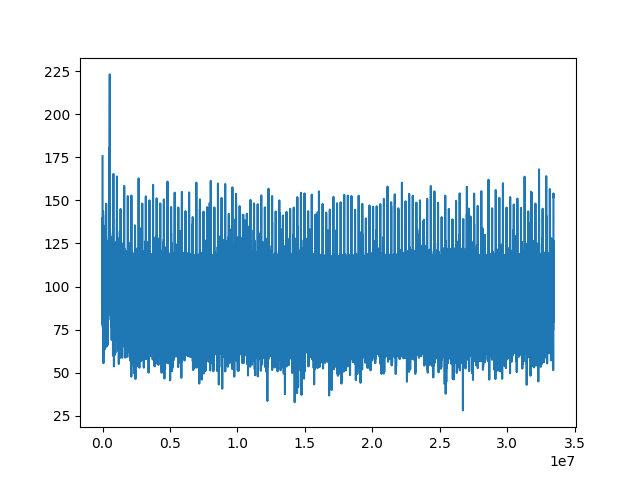

In [16]:
plt.close('all')
plt.figure()
#plt.plot(np.append(data[:,0], data[:,1]))
#plt.plot(data.T.reshape((RECORD_LENGTH//10*records_to_collect)))
plt.xlim(4*2**21 -100, 4*2**21+100)

plt.figure()
plt.plot(10*np.log10((np.abs(np.fft.fft(data.T.reshape(RECORD_LENGTH)))**2)[0:RECORD_LENGTH//2]))

In [59]:
np.log2(data.T.reshape((RECORD_LENGTH*records_to_collect)).shape)

array([25.])

In [106]:
print(data.shape)

print(np.log2(RECORD_LENGTH*records_to_collect))
print(np.log2(data.reshape((RECORD_LENGTH*records_to_collect)).shape))

(2097152, 16)
25.0
[25.]
